## Load Real Data and Pre-trained Models

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

# Load real financial data
data = pd.read_csv('../data/raw/sp500.csv', index_col='Date', parse_dates=True)
data = data.apply(pd.to_numeric, errors='coerce')
close_prices = data['Close']
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
log_returns_array = log_returns.values.reshape(-1, 1)

# Normalize again for consistent scaling
scaler = MinMaxScaler()
log_returns_scaled = scaler.fit_transform(log_returns_array)

print(f"Real data shape (log returns scaled): {log_returns_scaled.shape}")

# Load ARIMA model
arima_model = joblib.load('../models/arima_model.pkl')
print("ARIMA model loaded.")

# Load GARCH model
garch_model = joblib.load('../models/garch_model.pkl')
print("GARCH model loaded.")

# Load TimeGAN models
embedder = load_model('../models/timegan_embedder.h5')
recovery = load_model('../models/timegan_recovery.h5')
generator = load_model('../models/timegan_generator.h5')
discriminator = load_model('../models/timegan_discriminator.h5')
print("TimeGAN models loaded.")

Real data shape (log returns scaled): (6036, 1)
ARIMA model loaded.
GARCH model loaded.


TimeGAN models loaded.


## Generate Synthetic Data for Evaluation

In [11]:
import numpy as np

# ------ Generate Synthetic Data with TimeGAN -----

n_samples = 100  # Number of sequences
sequence_length = 24
z_dim = 8  # Same as during training

# Random noise for Generator
Z_synthetic = np.random.uniform(0, 1, size=(n_samples, sequence_length, z_dim)).astype(np.float32)

# Generate synthetic sequences
synthetic_timegan = generator.predict(Z_synthetic)

# Reshape (n_samples * sequence_length, 1)
synthetic_timegan_flat = synthetic_timegan.reshape(-1, 1)

# Rescale back to original scale
synthetic_timegan_rescaled = scaler.inverse_transform(synthetic_timegan_flat)

print(f"Generated {n_samples} synthetic sequences using TimeGAN.")


# ----- Generate Simulated Synthetic Data for VAE -----

# Here we simulate synthetic sequences similar to VAE outputs
synthetic_vae_simulated = np.random.normal(
    loc=np.mean(log_returns_scaled), 
    scale=np.std(log_returns_scaled), 
    size=(n_samples * sequence_length, 1)
)

# Rescale back to original log-return scale
synthetic_vae_rescaled = scaler.inverse_transform(synthetic_vae_simulated)

print(f"Generated {n_samples} synthetic sequences using Simulated VAE.")

# ----- Prepare Real Data -----

# Reshape real data to match format
real_data_prepared = log_returns_array[:n_samples * sequence_length]

print(f"Prepared real data with shape: {real_data_prepared.shape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Generated 100 synthetic sequences using TimeGAN.
Generated 100 synthetic sequences using Simulated VAE.
Prepared real data with shape: (2400, 1)


## PCA Visualization of Real vs TimeGAN vs VAE

New combined data shape: (300, 24)


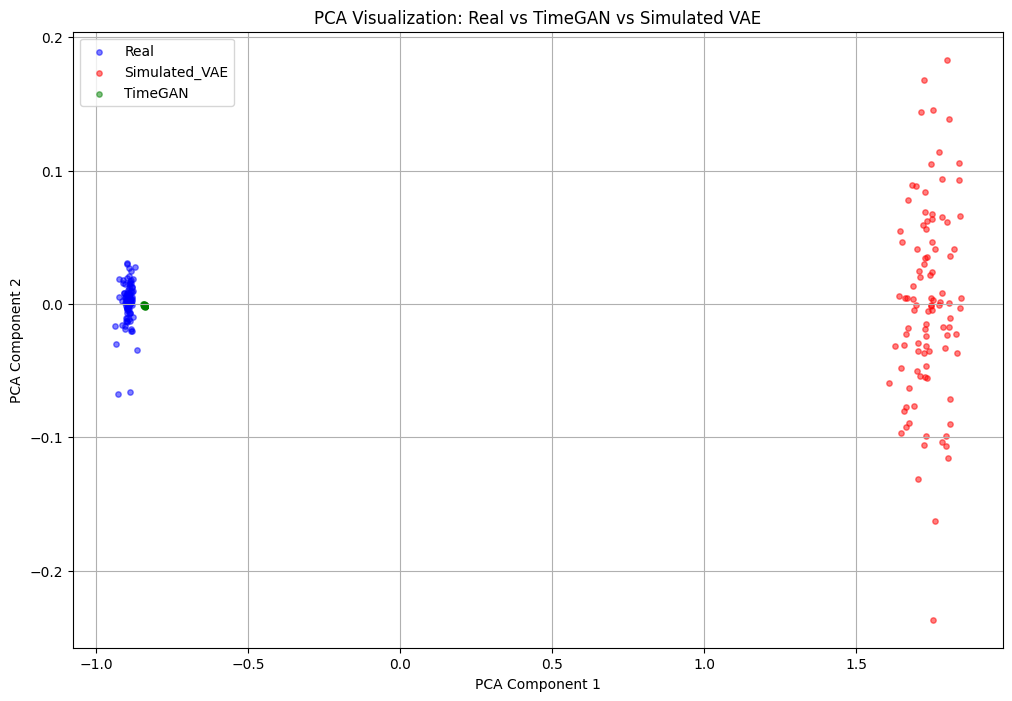

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Reshape all datasets into sequences
sequence_length = 24  # Same as used during generation

# Reshape real data
real_data_seq = real_data_prepared.reshape(-1, sequence_length)

# Reshape synthetic TimeGAN data
synthetic_timegan_seq = synthetic_timegan_rescaled.reshape(-1, sequence_length)

# Reshape synthetic VAE data
synthetic_vae_seq = synthetic_vae_simulated.reshape(-1, sequence_length)

# Combine datasets vertically
combined_data = np.vstack([
    real_data_seq,
    synthetic_timegan_seq,
    synthetic_vae_seq
])

# Create labels
labels = (
    ["Real"] * real_data_seq.shape[0] +
    ["TimeGAN"] * synthetic_timegan_seq.shape[0] +
    ["Simulated_VAE"] * synthetic_vae_seq.shape[0]
)

print(f"New combined data shape: {combined_data.shape}")

# 2. Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data)

# 3. Prepare color mapping
color_map = {
    "Real": "blue",
    "TimeGAN": "green",
    "Simulated_VAE": "red"
}

# 4. Plot PCA results
plt.figure(figsize=(12,8))
for label in np.unique(labels):
    indices = np.array(labels) == label
    plt.scatter(
        pca_result[indices, 0],
        pca_result[indices, 1],
        alpha=0.5,
        label=label,
        s=15,
        c=color_map[label]
    )

plt.title('PCA Visualization: Real vs TimeGAN vs Simulated VAE')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

## Compute MMD Distance between Real and Synthetic Data

In [13]:
import tensorflow as tf

def compute_mmd(x, y, kernel='rbf', sigma=1.0):
    """Compute the Maximum Mean Discrepancy (MMD) between two samples."""
    
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    
    if kernel == 'rbf':
        # Gaussian (RBF) kernel
        xx = tf.matmul(x, tf.transpose(x))
        yy = tf.matmul(y, tf.transpose(y))
        xy = tf.matmul(x, tf.transpose(y))
        
        rx = tf.expand_dims(tf.reduce_sum(x * x, axis=1), 0)
        ry = tf.expand_dims(tf.reduce_sum(y * y, axis=1), 0)
        
        Kxx = tf.exp(- (rx - 2 * xx + tf.transpose(rx)) / (2 * sigma ** 2))
        Kyy = tf.exp(- (ry - 2 * yy + tf.transpose(ry)) / (2 * sigma ** 2))
        Kxy = tf.exp(- (rx - 2 * xy + tf.transpose(ry)) / (2 * sigma ** 2))
        
        mmd = tf.reduce_mean(Kxx) + tf.reduce_mean(Kyy) - 2 * tf.reduce_mean(Kxy)
        
        return mmd.numpy()

# Compute MMD between Real and TimeGAN
mmd_timegan = compute_mmd(real_data_seq, synthetic_timegan_seq, sigma=1.0)
print(f"MMD (Real vs TimeGAN): {mmd_timegan:.6f}")

# Compute MMD between Real and Simulated VAE
mmd_vae = compute_mmd(real_data_seq, synthetic_vae_seq, sigma=1.0)
print(f"MMD (Real vs Simulated VAE): {mmd_vae:.6f}")

MMD (Real vs TimeGAN): 0.004423
MMD (Real vs Simulated VAE): 1.871836


## Save Synthetic Data for Use Cases

In [14]:
# Resave TimeGAN synthetic data
np.save('../data/processed/synthetic_timegan.npy', synthetic_timegan_rescaled)

# Resave Simulated VAE synthetic data
np.save('../data/processed/simulated_vae.npy', synthetic_vae_simulated)

print("Synthetic data saved successfully in /data/processed/")

Synthetic data saved successfully in /data/processed/
